In [3]:
import nest_asyncio
nest_asyncio.apply()

from mutabledataset import SimpleDataset
from agent import RationalAgent
from simulation import Simulation
from learner import LogisticLearner
import plot
import numpy as np
from learner import StatisticalParityLogisticLearner
from learner import FairLearnLearner
from learner import RejectOptionsLogisticLearner
from learner import ReweighingLogisticLearner
from IPython.display import display, Markdown, Latex
import matplotlib.pyplot as plt
import seaborn as sns

mutable_attr = 'x'
def do_sim(learner):
    cost_lambda = lambda x_new, x: pow(x_new/2.,2.)+3*abs(x_new-x)/4. #lambda x_new, x: x_new/2.+1*abs(x_new-x)/4.
    cost_fixed = lambda size: np.abs(np.random.normal(loc=0.5,scale=0.5,size=size))


    g = SimpleDataset(mutable_features=['x'],
            domains={'x': 'auto'},
            discrete=['x'],
            cost_fns={'x': cost_lambda})


    sim = Simulation(g,
                     RationalAgent,
                     learner,
                     cost_fixed,
                     collect_incentive_data=True)

    result_set = sim.start_simulation(runs=5)
    return result_set

def print_stats(result_set, name):
    print(result_set)
    print("StatPar Δ:", round(result_set.stat_parity_diff({'group': 0}, {'group': 1}),2))
    pre_up_mean, pre_up_std, post_up_mean, post_up_std = tuple(map(lambda x: round(x,2),result_set.feature_average(mutable_attr, {'group':0})))
    pre_p_mean, pre_p_std, post_p_mean, post_p_std = tuple(map(lambda x: round(x,2),result_set.feature_average(mutable_attr, {'group':1})))
    diff = abs(post_up_mean - post_p_mean)
    print("Feature x (mean):")
    print("(UP) Pre :", pre_up_mean, "(+-", pre_up_std, ")")
    print("(P) Pre  :", pre_p_mean, "(+-", pre_p_std, ")")
    print("(UP) Post:", post_up_mean, "(+-", post_up_std, ")")
    print("(P) Post :", post_p_mean, "(+-", post_p_std, ")")


    print("Post    Δ:", round(diff, 2))
    
    sns.set()
    plt.figure(name)
    ax = sns.lineplot(x=mutable_attr, y="incentive",hue='group',data=(rs._avg_incentive(mutable_attr, 'group')).reset_index())
    #plt.savefig(name+".png")



privileged_groups = [{'group': 1}]
unprivileged_groups = [{'group': 0}]

# Setup / Model
## Simple Dataset Distribution

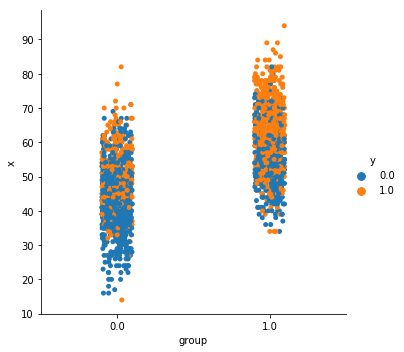

In [2]:
g = SimpleDataset(mutable_features=['x'],
        domains={'x': 'auto'},
        discrete=['x'],
        cost_fns={})
sns.catplot(x="group", y="x", hue="y", data=g.convert_to_dataframe()[0]);

## Cost Function
$c(x',x) = C + c_1(x')^2+ c_2|x' - x|$

where $C \sim N(0.5, 0.5)$, $c_1 = \frac{1}{4}$, $c_2 = \frac{3}{4}$.

As in our synthetic dataset *higher feature values are more desirable* and *our features are normalized*, the term $c_1(x')^2$ makes manipulations to the top of the distribution more expensive.

The second term $c_2|x' - x|$ incurrs a cost linear in the size of the manipulation.

## Incentive Function
$I(x',x) = h(x') - c(x',x)$

## Ground Truth Update
For every $x \in X$, which was manipulated during the simulation, we find the new ground truth by:
1. Find the $k=51$ closest neighbors in the *unchanged original dataset*
2. Set the label for the *manipulated x* to the label of the majority of the $k=51$ labels

The unmanipulated datapoints keep their old label.

## $\epsilon$ value
$$\epsilon = |acc_h(X_{test}, Y_{test}) - acc_h'(X'_{test}, Y'_{test})|$$
where $X'_{test}, Y'_{test}$ is the modified dataset after simulation and $h$ is the classifier fitted on the original dataset $(X_{train}, Y_{train})$ and $h'$ is the classifier fitted on the manipulated dataset $(X'_{test}, Y'_{test})$.

Low values of $\epsilon$ indicate that the original classifier $h$ is still a best response by the learner to the agents manipulations.

# Statistical Parity Story
With a certain cet of paremeters (cost functions, distribution input data), all methods which enforce statistical parity, lead to a greater difference in average feature value across the groups.

In [11]:
display(Markdown("### No Fairness Constraint:"))
rs = do_sim(LogisticLearner())
print_stats(rs, "noaff")
print("\n")

### No Fairness Constraint:

In [10]:
display(Markdown("### Reweighing (pre-process)"))
rs = do_sim(ReweighingLogisticLearner(privileged_groups, unprivileged_groups))
print_stats(rs, "pre")
print("\n")

(1000, 2) (1000, 2)


### Reweighing (pre-process)

ERROR! Session/line number was not unique in database. History logging moved to new session 134
(1000, 2) (1000, 2)


### Fairlearn (in-process)

ERROR! Session/line number was not unique in database. History logging moved to new session 135
(1000, 2) (1000, 2)
Runs:  1 
 Eps:  0.0  (+-  0.0 ) 
 Acc h:  0.21  (+-  0.0 ) 

(pre) up 0.313 , p 0.322
(post) up 0.313 , p 0.322
StatPar Δ: 0.01
Feature x (mean):
(UP) Pre : 0.52 (+- 0.0 )
(P) Pre  : 0.69 (+- 0.0 )
(UP) Post: 0.52 (+- 0.0 )
(P) Post : 0.69 (+- 0.0 )
Post    Δ: 0.17




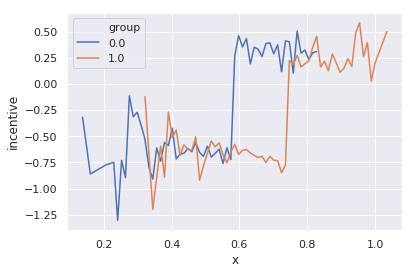

In [3]:
display(Markdown("### Fairlearn (in-process)"))
rs = do_sim(FairLearnLearner(privileged_groups, unprivileged_groups))
print_stats(rs, "in")
print("\n")

In [9]:
display(Markdown("### Reject Option (post-process)"))
rs = do_sim(RejectOptionsLogisticLearner(privileged_groups, unprivileged_groups))
print_stats(rs, "post")
print("\n")

### Reject Option (post-process)

(1000, 2) (1000, 2)


### DIY Booster (post-process)

(1000, 2) (1000, 2)
ERROR! Session/line number was not unique in database. History logging moved to new session 136
Runs:  1 
 Eps:  0.0  (+-  0.0 ) 
 Acc h:  0.4  (+-  0.0 ) 

(pre) up 0.719 , p 0.731
(post) up 0.719 , p 0.731
StatPar Δ: 0.01
Feature x (mean):
(UP) Pre : 0.49 (+- 0.0 )
(P) Pre  : 0.65 (+- 0.0 )
(UP) Post: 0.49 (+- 0.0 )
(P) Post : 0.65 (+- 0.0 )
Post    Δ: 0.16


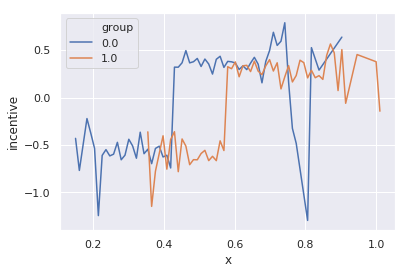

In [4]:
display(Markdown("### DIY Booster (post-process)"))
rs = do_sim(StatisticalParityLogisticLearner(privileged_groups, unprivileged_groups, eps=0.001))
print_stats(rs, "postDIY")

# German Dataset
The above effect is also present on a "real-world" dataset (UCI German Credit)

## Cost function
$c(x',x) = C + \sum c_1(x')^2+ c_2|x' - x|$

In [4]:
import itertools
from mutabledataset import SimpleDataset
from agent import RationalAgent
from simulation import Simulation
from learner import LogisticLearner
import pandas as pd
import plot
import numpy as np
from learner import StatisticalParityLogisticLearner
from learner import PrejudiceRemoverLearner
from learner import FairLearnLearner
from learner import RejectOptionsLogisticLearner
from learner import ReweighingLogisticLearner
from mutabledataset import GermanSimDataset
import matplotlib.pyplot as plt
import seaborn as sns

group_attr = 'foreign_worker'
mutable_attrs = ['credit_amount', 'month', 'savings', 'investment_as_income_percentage']

def do_sim(learner,l,m):
    print("l",l,"m",m)
    L = l
    M = m
    cp = lambda x_new, x: (pow(x_new/2.,2.)*(1-M)+abs(x_new-x)*M)*L
    cn = lambda x_new, x: (pow((1-x_new)/2.,2.)*(1-M)+abs(x_new-x)*M)*L 
    cost_fixed = lambda size: np.abs(np.random.normal(loc=.5,scale=1.0,size=size))

    g = GermanSimDataset(mutable_features=mutable_attrs,
            domains={k: 'auto' for k in mutable_attrs},
                         discrete=mutable_attrs,
                         protected_attribute_names=[group_attr],
                         cost_fns={'number_of_credits': cn, 'credit_amount': cn, 'month': cn, 'savings': cp, 'investment_as_income_percentage': cp},
                         privileged_classes=[[1]],
                         features_to_drop=['personal_status', 'sex', 'age'])#, 'credit_history','other_debtors','purpose','status','skill_level', 'employment', 'property', 'housing', 'people_liable_for', 'installment_plans','telephone','residence_since', 'age'])


    privileged_groups = [{group_attr: 1}]
    unprivileged_groups = [{group_attr: 0}]

    sim = Simulation(g,
                     RationalAgent,
                     learner,
                     cost_fixed,
                     split=[0.9],
                     collect_incentive_data=False)

    result_set = sim.start_simulation(runs=5)
    return result_set

def print_stats(result_set, name):
    print(result_set)
    print("StatPar Δ:", round(result_set.stat_parity_diff({group_attr: 0}, {group_attr: 1}),2))


    diff = 0
    movement = []
    movement_up = []
    # calc. difference in avg. over mutable attrs
    for mutable_attr in mutable_attrs:
        pre_up_mean, pre_up_std, post_up_mean, post_up_std = tuple(map(lambda x: round(x,2),result_set.feature_average(mutable_attr, {group_attr:0})))
        pre_p_mean, pre_p_std, post_p_mean, post_p_std = tuple(map(lambda x: round(x,2),result_set.feature_average(mutable_attr, {group_attr:1})))
        diff_pre = abs(pre_p_mean-pre_up_mean)
        diff += abs(post_p_mean-post_up_mean)
        movement.append(pre_p_mean-post_p_mean)
        movement_up.append(pre_up_mean-post_up_mean)
    print("Post    Δ:", round(diff, 2))
    print("Pre     Δ:", round(diff_pre,2))

l = 0.2
m = 0.9
privileged_groups = [{group_attr: 1}]
unprivileged_groups = [{group_attr: 0}]

In [8]:
display(Markdown("### No Fairness Constraint:"))
rs = do_sim(LogisticLearner(), l, m)
print_stats(rs, "nofair")

### No Fairness Constraint:

l 0.2 m 0.9
(900, 51) (100, 51)
Runs:  1 
 Eps:  0.02  (+-  0.0 ) 
 Acc h:  0.83  (+-  0.0 ) 

(pre) up 0.7497403946002077 , p 0.972972972972973
(post) up 0.7850467289719626 , p 1.0
StatPar Δ: 0.21
Post    Δ: 0.04
Pre     Δ: 0.03


In [7]:
display(Markdown("### Reweighing (pre-process)"))
rs = do_sim(ReweighingLogisticLearner(privileged_groups, unprivileged_groups),l,m)
print_stats(rs, "pre")

l 0.2 m 0.9
(900, 51) (100, 51)


### Reweighing (pre-process)

In [6]:
display(Markdown("### Fairlearn (in-process)"))
rs = do_sim(FairLearnLearner(privileged_groups, unprivileged_groups),l,m)
print_stats(rs, "in")

### Fairlearn (in-process)

l 0.2 m 0.9
(900, 51) (100, 51)
Runs:  1 
 Eps:  0.02  (+-  0.0 ) 
 Acc h:  0.67  (+-  0.0 ) 

(pre) up 0.7476635514018691 , p 0.7297297297297297
(post) up 0.7964693665628245 , p 0.7837837837837838
StatPar Δ: 0.01
Post    Δ: 0.06
Pre     Δ: 0.03


In [7]:
display(Markdown("### Reject Option (post-process)"))
rs = do_sim(RejectOptionsLogisticLearner(privileged_groups, unprivileged_groups),l,m)
print_stats(rs, "post")

### Reject Option (post-process)

l 0.2 m 0.9
(900, 51) (100, 51)
Runs:  1 
 Eps:  0.03  (+-  0.0 ) 
 Acc h:  0.52  (+-  0.0 ) 

(pre) up 0.6002076843198338 , p 0.6486486486486487
(post) up 0.6313603322949117 , p 0.6486486486486487
StatPar Δ: 0.02
Post    Δ: 0.03
Pre     Δ: 0.03


In [ ]:
display(Markdown("### DIY Booster (post-process)"))
rs = do_sim(StatisticalParityLogisticLearner(privileged_groups, unprivileged_groups, eps=0.001),l,m)
print_stats(rs, "postDIY")